# DAT210x - Programming with Python for DS

## Module5- Lab6

In [3]:
import random, math
import pandas as pd
import numpy as np
import scipy.io

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot') # Look Pretty


# Leave this alone until indicated:
Test_PCA = False

### A Convenience Function

This method is for your visualization convenience only. You aren't expected to know how to put this together yourself, although you should be able to follow the code by now:

In [4]:
def Plot2DBoundary(DTrain, LTrain, DTest, LTest):
    # The dots are training samples (img not drawn), and the pics are testing samples (images drawn)
    # Play around with the K values. This is very controlled dataset so it should be able to get perfect classification on testing entries
    # Play with the K for isomap, play with the K for neighbors. 

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Transformed Boundary, Image Space -> 2D')

    padding = 0.1   # Zoom out
    resolution = 1  # Don't get too detailed; smaller values (finer rez) will take longer to compute
    colors = ['blue','green','orange','red']


    # ------

    # Calculate the boundaries of the mesh grid. The mesh grid is
    # a standard grid (think graph paper), where each point will be
    # sent to the classifier (KNeighbors) to predict what class it
    # belongs to. This is why KNeighbors has to be trained against
    # 2D data, so we can produce this countour. Once we have the 
    # label for each point on the grid, we can color it appropriately
    # and plot it.
    x_min, x_max = DTrain[:, 0].min(), DTrain[:, 0].max()
    y_min, y_max = DTrain[:, 1].min(), DTrain[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Using the boundaries, actually make the 2D Grid Matrix:
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # What class does the classifier say about each spot on the chart?
    # The values stored in the matrix are the predictions of the model
    # at said location:
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the mesh grid as a filled contour plot:
    plt.contourf(xx, yy, Z, cmap=plt.cm.terrain, z=-100)


    # ------

    # When plotting the testing images, used to validate if the algorithm
    # is functioning correctly, size them as 5% of the overall chart size
    x_size = x_range * 0.05
    y_size = y_range * 0.05

    # First, plot the images in your TEST dataset
    img_num = 0
    for index in LTest.index:
        # DTest is a regular NDArray, so you'll iterate over that 1 at a time.
        x0, y0 = DTest[img_num,0]-x_size/2., DTest[img_num,1]-y_size/2.
        x1, y1 = DTest[img_num,0]+x_size/2., DTest[img_num,1]+y_size/2.

        # DTest = our images isomap-transformed into 2D. But we still want
        # to plot the original image, so we look to the original, untouched
        # dataset (at index) to get the pixels:
        img = df.iloc[index,:].reshape(num_pixels, num_pixels)
        ax.imshow(img,
                  aspect='auto',
                  cmap=plt.cm.gray,
                  interpolation='nearest',
                  zorder=100000,
                  extent=(x0, x1, y0, y1),
                  alpha=0.8)
        img_num += 1


    # Plot your TRAINING points as well... as points rather than as images
    for label in range(len(np.unique(LTrain))):
        indices = np.where(LTrain == label)
        ax.scatter(DTrain[indices, 0], DTrain[indices, 1], c=colors[label], alpha=0.8, marker='o')

    # Plot
    plt.show()  

### The Assignment

Use the same code from Module4/assignment4.ipynb to load up the `face_data.mat` file into a dataframe called `df`. Be sure to calculate the `num_pixels` value, and to rotate the images to being right-side-up instead of sideways. This was demonstrated in the [Lab Assignment 4](https://github.com/authman/DAT210x/blob/master/Module4/assignment4.ipynb) code.

In [10]:
# .. your code here ..
mat = scipy.io.loadmat('Datasets/face_data.mat')
df = pd.DataFrame(mat['images']).T
num_images, num_pixels = df.shape
num_pixels = int(math.sqrt(num_pixels))

# Rotate the pictures, so we don't have to crane our necks:
for i in range(num_images):
    df.loc[i,:] = df.loc[i,:].reshape(num_pixels, num_pixels).T.reshape(-1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Load up your face_labels dataset. It only has a single column, and you're only interested in that single column. You will have to slice the  column out so that you have access to it as a "Series" rather than as a "Dataframe". This was discussed in the the "Slicin'" lecture of the  "Manipulating Data" reading on the course website. Use an appropriate indexer to take care of that. Be sure to print out the labels and compare what you see to the raw `face_labels.csv` so you know you loaded it correctly.

In [14]:
# .. your code here ..
labels = pd.read_csv('Datasets/face_labels.csv',header=None)
y = labels.iloc[:,0:1]


Do `train_test_split`. Use the same code as on the EdX platform in the reading material, but set the random_state=7 for reproducibility, and the test_size to 0.15 (150%). Your labels are actually passed in as a series (instead of as an NDArray) so that you can access their underlying indices later on. This is necessary so you can find your samples in the original dataframe. The convenience methods we've written for you that handle drawing expect this, so that they can plot your testing data as images rather than as points:

In [16]:
# .. your code here ..
from sklearn.model_selection import train_test_split

x_train, x_test, label_train, label_test = train_test_split(df, y, test_size=0.15, random_state=7)

### Dimensionality Reduction

In [19]:
from sklearn import manifold

if Test_PCA:
    # INFO: PCA is used *before* KNeighbors to simplify your high dimensionality
    # image samples down to just 2 principal components! A lot of information
    # (variance) is lost during the process, as I'm sure you can imagine. But
    # you have to drop the dimension down to two, otherwise you wouldn't be able
    # to visualize a 2D decision surface / boundary. In the wild, you'd probably
    # leave in a lot more dimensions, which is better for higher accuracy, but
    # worse for visualizing the decision boundary;
    #
    # Your model should only be trained (fit) against the training data (data_train)
    # Once you've done this, you need use the model to transform both data_train
    # and data_test from their original high-D image feature space, down to 2D


    # TODO: Implement PCA here. ONLY train against your training data, but
    # transform both your training + test data, storing the results back into
    # data_train, and data_test.
    
    # .. your code here ..
    print('pca not used')
else:
    # INFO: Isomap is used *before* KNeighbors to simplify your high dimensionality
    # image samples down to just 2 components! A lot of information has been is
    # lost during the process, as I'm sure you can imagine. But if you have
    # non-linear data that can be represented on a 2D manifold, you probably will
    # be left with a far superior dataset to use for classification. Plus by
    # having the images in 2D space, you can plot them as well as visualize a 2D
    # decision surface / boundary. In the wild, you'd probably leave in a lot more
    # dimensions, which is better for higher accuracy, but worse for visualizing the
    # decision boundary;
    
    # Your model should only be trained (fit) against the training data (data_train)
    # Once you've done this, you need use the model to transform both data_train
    # and data_test from their original high-D image feature space, down to 2D

    
    # TODO: Implement Isomap here. ONLY train against your training data, but
    # transform both your training + test data, storing the results back into
    # data_train, and data_test.
    
    # .. your code here ..
        n_neighbors = 5
        n_components = 2
        iso = manifold.Isomap(n_neighbors, n_components).fit(x_train)
        data_train = iso.transform(x_train)
        data_test = iso.transform(x_test)
    
    

Implement `KNeighborsClassifier` here. You can use any K value from 1 through 20, so play around with it and attempt to get good accuracy. Fit the classifier against your training data and labels.

In [26]:
# .. your code here ..
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(data_train, label_train) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Calculate and display the accuracy of the testing set (data_test and label_test):

In [27]:
# .. your code here ..
model.score(data_test,label_test)

0.96190476190476193

Let's chart the combined decision boundary, the training data as 2D plots, and the testing data as small images so we can visually validate performance:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


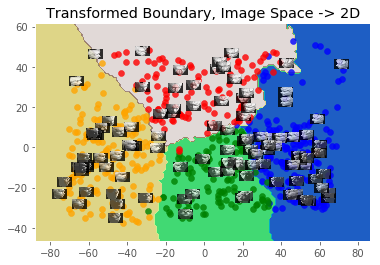

In [28]:
Plot2DBoundary(data_train, label_train, data_test, label_test)

After submitting your answers, experiment with using using PCA instead of ISOMap. Are the results what you expected? Also try tinkering around with the test/train split percentage from 10-20%. Notice anything?

In [ ]:
# .. your code changes above ..